In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import hvplot.pandas
#import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
#loading the file
lmb_data = pd.read_csv('../Downloads/lmb-data.csv')

In [4]:
lmb_data.head()

,state,district,incmbncy,demvote,repvote,year,congress,occupanc,name,eq_Dwhip,...,pres_rep_pct,n,lagged,_merge,democrat,lagdemocrat,score,lagscore,id,id2
0,1,1,-1.0,127802.0,103294.0,1948,81,0.0,"RIBICOFF,",0.752336,...,NaN,1,14.760000,3,1,0,64.339996,14.760000,3,1
1,1,1,-1.0,127802.0,103294.0,1948,81,0.0,"RIBICOFF,",0.752336,...,NaN,2,9.520001,3,1,0,60.279999,9.520001,4,1
2,1,1,1.0,134258.0,96251.0,1950,82,0.0,"RIBICOFF,",0.770270,...,NaN,1,64.339996,3,1,1,57.060001,64.339996,5,1
3,1,1,1.0,134258.0,96251.0,1950,82,0.0,"RIBICOFF,",0.770270,...,NaN,2,60.279999,3,1,1,73.830002,60.279999,6,1
4,1,1,1.0,148935.0,112526.0,1954,84,0.0,DODD,0.730769,...,NaN,1,56.220001,3,1,1,42.959999,56.220001,7,1


In [5]:
lmb_data.columns

Index(['state', 'district', 'incmbncy', 'demvote', 'repvote', 'year',
       'congress', 'occupanc', 'name', 'eq_Dwhip',
       ...
       'pres_rep_pct', 'n', 'lagged', '_merge', 'democrat', 'lagdemocrat',
       'score', 'lagscore', 'id', 'id2'],
      dtype='object', length=178)

In [6]:
def lm_robust(formula, data):
    regression = sm.OLS.from_formula(formula, data = data)
    regression = regression.fit(cov_type="cluster",cov_kwds={"groups":data['id']})
    return regression

In [7]:
from itertools import combinations 
import plotnine as p

### 1(a) No bandwidth

In [8]:
lmb_data['demvoteshare_c'] = lmb_data['demvoteshare'] - 0.5
# drop missing values
lmb_data = lmb_data[~pd.isnull(lmb_data.demvoteshare_c)]
lmb_data['demvoteshare_sq'] = lmb_data['demvoteshare_c']**2

#aggregating the data
#lmb_data = lmb_data[lmb_data.demvoteshare.between(.45, .55)]
categories = lmb_data.lagdemvoteshare
lmb_data['lagdemvoteshare_100'] = pd.cut(lmb_data.lagdemvoteshare, 100)

agg_lmb_data = lmb_data.groupby('lagdemvoteshare_100')['score'].mean().reset_index()
lmb_data['gg_group'] = [1 if x>.5 else 0 for x in lmb_data.lagdemvoteshare]
agg_lmb_data['lagdemvoteshare'] = np.arange(0.01, 1.01, .01)

C:\Users\zhaoy\anaconda3\envs\pyvizenv\lib\site-packages\plotnine\scales\scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

C:\Users\zhaoy\anaconda3\envs\pyvizenv\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 13 rows containing missing values.


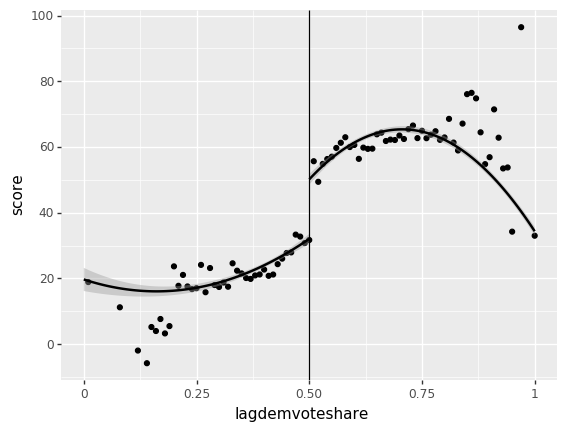

In [11]:
# quadratic plot
plot = (p.ggplot(lmb_data, p.aes('lagdemvoteshare', 'score')) +    p.geom_point(p.aes(x = 'lagdemvoteshare', y = 'score'), data = agg_lmb_data) +    p.stat_smooth(p.aes('lagdemvoteshare', 'score', group = 'gg_group'), 
                  data=lmb_data, method = "lm", 
              formula = 'y ~ x + I(x**2)') +\
    p.xlim(0,1) + p.ylim(0,100) +\
    p.geom_vline(xintercept = 0.5)
       )

plot += p.scale_y_continuous(breaks=range(0, int(lmb_data['score'].max()) + 20, 20))

print(plot)

C:\Users\zhaoy\anaconda3\envs\pyvizenv\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 15 rows containing missing values.


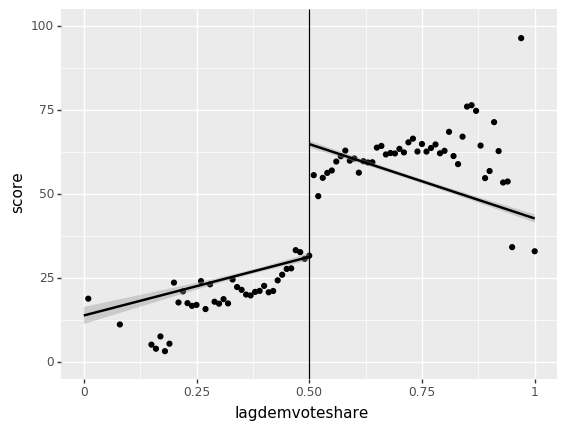

<ggplot: (-9223371908751057308)>

In [10]:
# Linear plot
p.ggplot(lmb_data, p.aes('lagdemvoteshare', 'score')) +    p.geom_point(p.aes(x = 'lagdemvoteshare', y = 'score'), data = agg_lmb_data) +    p.stat_smooth(p.aes('lagdemvoteshare', 'score', group = 'gg_group'), 
                  data=lmb_data, method = "lm")+\
    p.xlim(0,1) + p.ylim(0,100) +\
    p.geom_vline(xintercept = 0.5)

### 1(b) A bandwidth of +/- 0.05 around the threshold

In [12]:
lmb_data2 = lmb_data.copy()

In [13]:
lmb_data2['demvoteshare_c'] = lmb_data2['demvoteshare'] - 0.5
# drop missing values
lmb_data2 = lmb_data2[~pd.isnull(lmb_data2.demvoteshare_c)]
lmb_data2['demvoteshare_sq'] = lmb_data2['demvoteshare_c']**2

#aggregating the data
lmb_data2 = lmb_data2[lmb_data2.demvoteshare.between(.45, .55)]
categories2 = lmb_data2.lagdemvoteshare
lmb_data2['lagdemvoteshare_100'] = pd.cut(lmb_data2.lagdemvoteshare, 100)

agg_lmb_data2 = lmb_data2.groupby('lagdemvoteshare_100')['score'].mean().reset_index()
lmb_data2['gg_group'] = [1 if x>.5 else 0 for x in lmb_data2.lagdemvoteshare]
agg_lmb_data2['lagdemvoteshare'] = np.arange(0.01, 1.01, .01)

C:\Users\zhaoy\anaconda3\envs\pyvizenv\lib\site-packages\plotnine\scales\scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

C:\Users\zhaoy\anaconda3\envs\pyvizenv\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


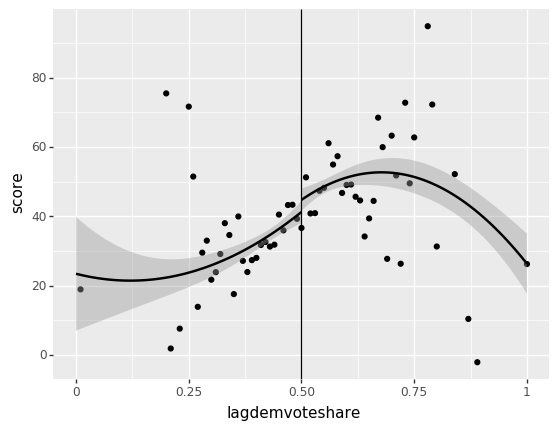

In [14]:
# quadratic plot
plot2 = (p.ggplot(lmb_data2, p.aes('lagdemvoteshare', 'score')) +    p.geom_point(p.aes(x = 'lagdemvoteshare', y = 'score'), data = agg_lmb_data2) +    p.stat_smooth(p.aes('lagdemvoteshare', 'score', group = 'gg_group'), 
                  data=lmb_data2, method = "lm", 
              formula = 'y ~ x + I(x**2)') +\
    p.xlim(0,1) + p.ylim(0,100) +\
    p.geom_vline(xintercept = 0.5)
       )

plot2 += p.scale_y_continuous(breaks=range(0, int(lmb_data2['score'].max()) + 20, 20))

print(plot2)

C:\Users\zhaoy\anaconda3\envs\pyvizenv\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 39 rows containing missing values.


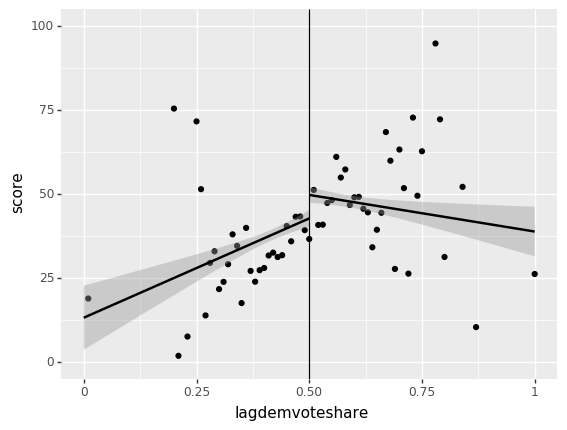

<ggplot: (-9223371908751115780)>

In [15]:
# Linear plot
p.ggplot(lmb_data2, p.aes('lagdemvoteshare', 'score')) +    p.geom_point(p.aes(x = 'lagdemvoteshare', y = 'score'), data = agg_lmb_data2) +    p.stat_smooth(p.aes('lagdemvoteshare', 'score', group = 'gg_group'), 
                  data=lmb_data2, method = "lm")+\
    p.xlim(0,1) + p.ylim(0,100) +\
    p.geom_vline(xintercept = 0.5)

In [17]:
agg_lmb_data.head()

,lagdemvoteshare_100,score,lagdemvoteshare
0,"(-0.001, 0.01]",18.909834,0.01
1,"(0.01, 0.02]",NaN,0.02
2,"(0.02, 0.03]",NaN,0.03
3,"(0.03, 0.04]",NaN,0.04
4,"(0.04, 0.05]",NaN,0.05


In [23]:
# Linear Regression within the specified bandwidth
linear_model = smf.ols('score ~ lagdemvoteshare + democrat', data=lmb_data2).fit()

# For the quadratic regression, we need to add a squared term of the running variable
lmb_data2['lagdemvoteshare_squared'] = lmb_data2['lagdemvoteshare'] ** 2
quadratic_model = smf.ols('score ~ lagdemvoteshare + lagdemvoteshare_squared + democrat', data=lmb_data2).fit()

# Summary of the linear and quadratic models
linear_model_summary = linear_model.summary()
quadratic_model_summary = quadratic_model.summary()

linear_model_summary, quadratic_model_summary


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                  score   R-squared:                       0.564
 Model:                            OLS   Adj. R-squared:                  0.564
 Method:                 Least Squares   F-statistic:                     1543.
 Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
 Time:                        18:48:42   Log-Likelihood:                -10624.
 No. Observations:                2385   AIC:                         2.125e+04
 Df Residuals:                    2382   BIC:                         2.127e+04
 Df Model:                           2                                         
 Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
 ----------------------------------------------------------------